In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DOMAIN: Entertainment
• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the
• DATA DESCRIPTION: The dataset comprises of images and its mask for corresponding human face.

## 1. Import and Understand the data

### A. Import and read ‘images.npy’.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import mobilenet_v2,MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization,Activation, Conv2DTranspose, Concatenate,Reshape,ZeroPadding2D, Convolution2D,MaxPooling2D, Dense,Flatten,Softmax,Dropout
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
import pandas as pd
import glob
import os
from tensorflow.keras.metrics import Recall, Precision
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
# Standarize features
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img,img_to_array, array_to_img
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

In [3]:
#Copy the images.npy file into google colab machine
!cp "/content/drive/My Drive/Colab Notebooks/Images.npy" .

In [4]:
# Load the images into memory
img_arr = np.load('Images.npy', allow_pickle=True)

In [5]:
#Print the shape
print("Images shape:" , img_arr.shape)

Images shape: (393, 2)


### B. Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [6]:
# Seperate the images and its label into two different array
images = img_arr[:,0]
mask = img_arr[:,1]

In [7]:
print(images.shape)
print(mask.shape)

(393,)
(393,)


In [8]:
# images= [img[...,::-1] for img in images]
# images = np.array(images)

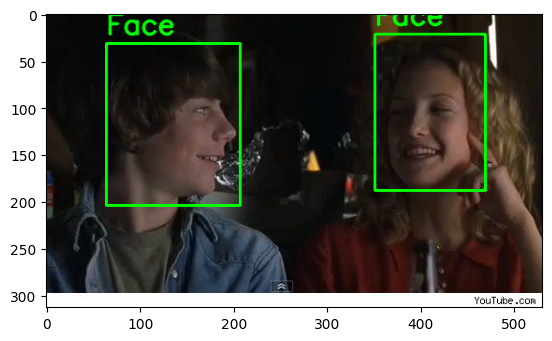

In [9]:
#Pickup a random image number and print its boundary box on the image

img_num = np.random.randint(0, mask.shape[0])
#Read the image and draw a rectangle as per bounding box information
rand_img = images[img_num]
for label in range(len(mask[img_num])):
  obj = mask[img_num][label]
  label = obj['label']
  w = obj['imageWidth']
  h = obj['imageHeight']
  x_min = obj['points'][0]['x']*w
  y_min = obj['points'][0]['y']*h
  x_max = obj['points'][1]['x']*w
  y_max = obj['points'][1]['y']*h
  rand_img = cv2.rectangle(rand_img,
              (int(x_min),int(y_min)),
              (int(x_max),int(y_max)),
              (0,255,0),
              2)
   #Add Label - Class name and confidence level
  label = label[0] + "";
  rand_img = cv2.putText(rand_img, label, (int(x_min), int(y_min-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)

#Convert BGR format (used by opencv to RGB format used by matplotlib)
#rand_img = cv2.cvtColor(rand_img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.imshow(rand_img)
plt.show()

In [10]:
# set the default size is 224x224
IMG_WIDTH =224
IMG_HEIGHT=224

In [11]:
# resize image and replace points by 1 which is in bounding box
y = np.zeros((int(images.shape[0]),IMG_HEIGHT, IMG_WIDTH))
X = np.zeros((int(images.shape[0]),IMG_HEIGHT, IMG_WIDTH, 3))
from PIL import Image
for index in range(len(images)):
  img = images[index];
  img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  try:
    img = img[:, :, :3]
  except:
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  for i in range(len(mask[index])):
    obj = mask[index][i]
    w = obj['imageWidth']
    h = obj['imageHeight']
    w_scale = IMG_WIDTH
    h_scale = IMG_HEIGHT
    x_min = int(obj['points'][0]['x']*w_scale)
    y_min = int(obj['points'][0]['y']*h_scale)
    x_max = int(obj['points'][1]['x']*w_scale)
    y_max = int(obj['points'][1]['y']*h_scale)
    y[index][y_min:y_max, x_min:x_max] = 1

In [12]:
#Prepare X and y and print its shape
print(X.shape)
print(y.shape)

(393, 224, 224, 3)
(393, 224, 224)


### C. Split the data into train and test[400:9].

In [13]:
X_train = X[0:384]
y_train =  y[0:384]

X_test = X[384:393]
y_test = y[384:393]

### D. Select random image from the train data and display original image and masked image.

image number  243


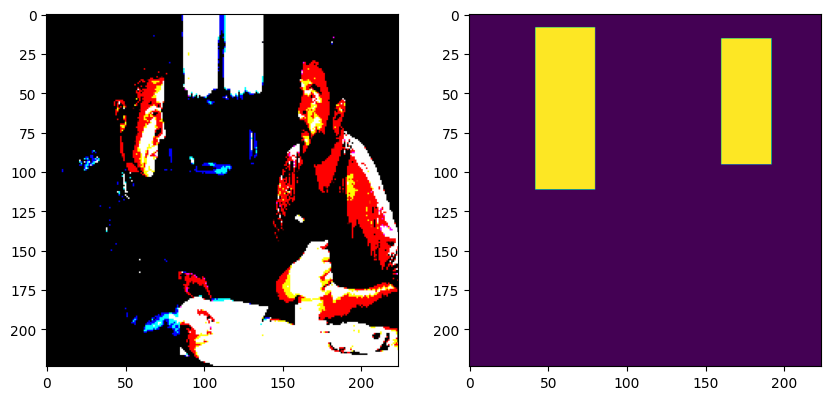

In [14]:
img_num = np.random.randint(0, X_train.shape[0])
print('image number ', img_num)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cv2.cvtColor(X_train[img_num].astype('float32'), cv2.COLOR_BGR2RGB))
ax[1].imshow(y_train[img_num])

# 2. Model building

### A. Design a face mask detection model.

In [15]:
def conv_block(inputs, num_filters):
  x = Conv2D(num_filters, 3, padding="same", kernel_initializer = 'he_normal')(inputs)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)


  x = Conv2D(num_filters, 3, padding="same", kernel_initializer = 'he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

def decoder_block(inputs, skip, num_filters):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs)
  x = Concatenate()([x, skip])
  x = tf.keras.layers.Dropout(0.3)(x)
  x = conv_block(x, num_filters)
  return x;

def buildMobileNet_v2_unet(input_shape, trainable=False):
  inputs = Input(shape=input_shape)
  encoder = MobileNetV2(input_tensor=inputs,include_top=False, alpha=0.35, weights = "imagenet")
  #encoder.summary()
  for layer in encoder.layers:
      layer.trainable = trainable
  ### Skip Connection
  s1 = encoder.get_layer("input_1").output                             # (224, 224,)
  s2 = encoder.get_layer("block_1_expand_relu").output                #  (112, 112,)
  s3 = encoder.get_layer("block_3_expand_relu").output                #  (56, 56,)
  s4 = encoder.get_layer("block_6_expand_relu").output                #  (28, 28,)
  #print(s1.shape, s2.shape, s3.shape, s4.shape,s5.shape)

  """ Bridge"""
  b1 = encoder.get_layer("block_13_expand_relu").output                #  (14, 14,)

  """ Decoder """

  d1 = decoder_block(b1,s4, 64)               #  (28, 28,)
  print(d1.shape)
  d2 = decoder_block(d1,s3, 48)               #  (56, 56,)
  print(d2.shape)
  d3 = decoder_block(d2,s2, 32)               #  (112, 112,)
  print(d3.shape)
  d4 = decoder_block(d3,s1, 16)               #  (256, 256,)
  print(d4.shape)
  #print(d1.shape, d2.shape, d3.shape, d4.shape,  d5.shape)

  outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
  model = Model(inputs, outputs, name="mobileNetV2_U-Net")
  return model
model= buildMobileNet_v2_unet((224,224,3))
model.summary()

2019640/2019640 [==============================] - 0s 0us/step
(None, 28, 28, 64)
(None, 56, 56, 48)
(None, 112, 112, 32)
(None, 224, 224, 16)
Model: "mobileNetV2_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 16)         432       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 16)         64        ['Conv1[0][0]']               
 on)                                                                                              
                                      

### B. Design your own Dice Coefficient and Loss function.

In [16]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
model.compile(optimizer='adam', loss=dice_loss, metrics = ["acc", dice_coef, Recall(), Precision()])

### C. Train and tune the model as required.

In [17]:
checkpoint = ModelCheckpoint("Q1/model.h5", monitor="val_loss", verbose=1, save_best_only=True,
                              mode="min")
stop = EarlyStopping(monitor="val_loss", patience=7, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [18]:
BATCH = 2
train_steps = len(X_train)//BATCH
valid_steps = len(X_test)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_test) % BATCH != 0:
    valid_steps += 1
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[checkpoint,reduce_lr,stop]
)

Epoch 1/10
192/192 [==============================] - ETA: 0s - loss: 0.6662 - acc: 0.6940 - dice_coef: 0.3338 - recall: 0.7425 - precision: 0.2552
Epoch 1: val_loss improved from inf to 0.72377, saving model to Q1/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


192/192 [==============================] - 168s 835ms/step - loss: 0.6662 - acc: 0.6940 - dice_coef: 0.3338 - recall: 0.7425 - precision: 0.2552 - val_loss: 0.7238 - val_acc: 0.5227 - val_dice_coef: 0.2635 - val_recall: 0.9751 - val_precision: 0.1807 - lr: 0.0010
Epoch 2/10
192/192 [==============================] - ETA: 0s - loss: 0.5211 - acc: 0.8544 - dice_coef: 0.4789 - recall: 0.6553 - precision: 0.4474
Epoch 2: val_loss improved from 0.72377 to 0.62481, saving model to Q1/model.h5
192/192 [==============================] - 192s 1s/step - loss: 0.5211 - acc: 0.8544 - dice_coef: 0.4789 - recall: 0.6553 - precision: 0.4474 - val_loss: 0.6248 - val_acc: 0.7442 - val_dice_coef: 0.3579 - val_recall: 0.8283 - val_precision: 0.2725 - lr: 0.0010
Epoch 3/10
192/192 [==============================] - ETA: 0s - loss: 0.4727 - acc: 0.8783 - dice_coef: 0.5273 - recall: 0.6086 - precision: 0.5152
Epoch 3: val_loss improved from 0.62481 to 0.51362, saving model to Q1/model.h5
192/192 [==========

### D. Evaluate and share insights on performance of the model.

In [19]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

5/5 [==============================] - 1s 137ms/step - loss: 0.5621 - acc: 0.9109 - dice_coef: 0.3942 - recall: 0.3661 - precision: 0.6514


[0.5620601177215576,
 0.9109025001525879,
 0.39418429136276245,
 0.3660719692707062,
 0.6513872742652893]

Insights:

1) Model is overfitting. Loss is very less in training but high in testing.

2) Dice Coef is good in training but low in testing.

3) To overcome the problem of overfitting, More images need to be added .

## 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

In [20]:
def display_model_prediction(img_num):

    #Read Seismic image and corresponding mask
    test_img = X_test[img_num]
    feat_scaled = np.expand_dims(test_img , axis=0)
    y_pred= model.predict(feat_scaled)
    pred_mask = cv2.resize((1.0*(y_pred[0] > 0.4)), (IMG_WIDTH,IMG_WIDTH))

    image2 = test_img.copy()
    image2[:,:,0] = pred_mask*test_img[:,:,0]
    image2[:,:,1] = pred_mask*test_img[:,:,1]
    image2[:,:,2] = pred_mask*test_img[:,:,2]

    out_image = image2
    #print(out_image.shape)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (12, 8))

    #Show both images
    ax1.set_title('Seismic')

    ax1.imshow(cv2.cvtColor(test_img.astype('float32'), cv2.COLOR_BGR2RGB), cmap = 'seismic', interpolation = 'bilinear')
    #ax1.imshow(test_img, cmap = 'seismic', interpolation = 'bilinear')
    ax2.set_title('Actual Mask')
    ax2.imshow(y_test[img_num], cmap = 'gray', interpolation = 'bilinear')
    ax3.set_title('Predicted face')
    ax3.imshow(cv2.cvtColor(out_image.astype('float32'), cv2.COLOR_BGR2RGB), alpha=1)
    ax4.set_title('Predicted Mask')
    ax4.imshow(pred_mask, alpha=1)

    plt.show()

1/1 [==============================] - 2s 2s/step


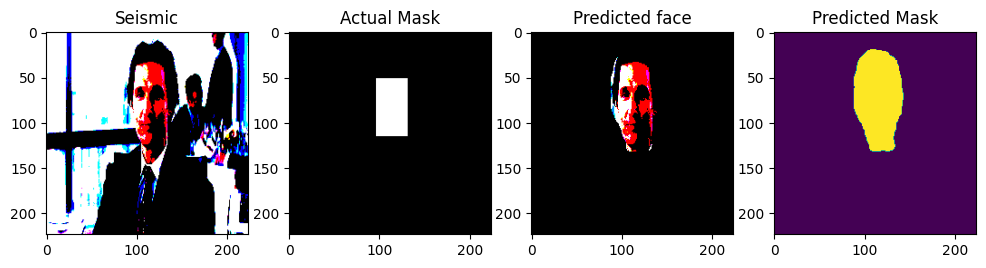

In [21]:
display_model_prediction(3)

# PART B

DOMAIN: Entertainment

• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription
basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on
the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer
vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the

• DATA DESCRIPTION: The dataset comprises of face images.

• PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

In [22]:
!cp "/content/drive/My Drive/Colab Notebooks/training_images.zip" .

In [23]:
!unzip training_images.zip

Archive:  training_images.zip
  inflating: training_images/real_00947.jpg  
  inflating: training_images/real_01052.jpg  
  inflating: training_images/real_01042.jpg  
  inflating: training_images/real_00964.jpg  
  inflating: training_images/real_01053.jpg  
  inflating: training_images/real_00971.jpg  
  inflating: training_images/real_01057.jpg  
  inflating: training_images/real_01044.jpg  
  inflating: training_images/real_01041.jpg  
  inflating: training_images/real_01067.jpg  
  inflating: training_images/real_00969.jpg  
  inflating: training_images/real_00956.jpg  
  inflating: training_images/real_00975.jpg  
  inflating: training_images/real_01021.jpg  
  inflating: training_images/real_00945.jpg  
  inflating: training_images/real_01068.jpg  
  inflating: training_images/real_01062.jpg  
  inflating: training_images/real_01016.jpg  
  inflating: training_images/real_01065.jpg  
  inflating: training_images/real_01027.jpg  
  inflating: training_images/real_00961.jpg  
  in

In [24]:
!ls -ls training_images

total 122204
112 -rw-r--r-- 1 root root 113848 Oct 16  2019  real_00001.jpg
100 -rw-r--r-- 1 root root  99198 Oct 16  2019  real_00002.jpg
144 -rw-r--r-- 1 root root 145564 Oct 16  2019  real_00003.jpg
136 -rw-r--r-- 1 root root 135198 Oct 16  2019  real_00004.jpg
124 -rw-r--r-- 1 root root 125060 Oct 16  2019  real_00005.jpg
112 -rw-r--r-- 1 root root 113294 Oct 16  2019  real_00006.jpg
140 -rw-r--r-- 1 root root 139881 Oct 16  2019  real_00007.jpg
132 -rw-r--r-- 1 root root 132152 Oct 16  2019  real_00008.jpg
140 -rw-r--r-- 1 root root 141830 Oct 16  2019  real_00009.jpg
104 -rw-r--r-- 1 root root 103347 Oct 16  2019  real_00010.jpg
168 -rw-r--r-- 1 root root 169147 Oct 16  2019  real_00011.jpg
124 -rw-r--r-- 1 root root 126060 Oct 16  2019  real_00012.jpg
132 -rw-r--r-- 1 root root 134739 Oct 16  2019  real_00013.jpg
112 -rw-r--r-- 1 root root 111357 Oct 16  2019  real_00014.jpg
 72 -rw-r--r-- 1 root root  73710 Oct 16  2019  real_00015.jpg
 64 -rw-r--r-- 1 root root  63801 Oct 16  

In [25]:
# Iterate over all the images and converted into array
images = glob.glob('training_images/*.jpg')
img_list = [cv2.imread(img) for img in images]
img_list_arr = np.array(img_list)

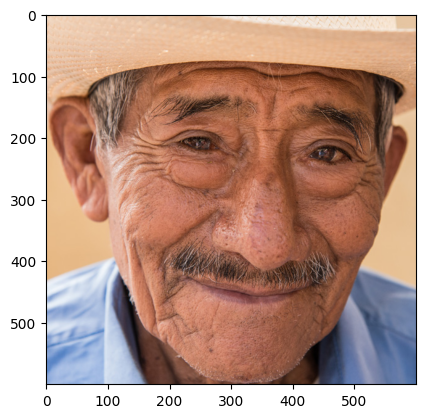

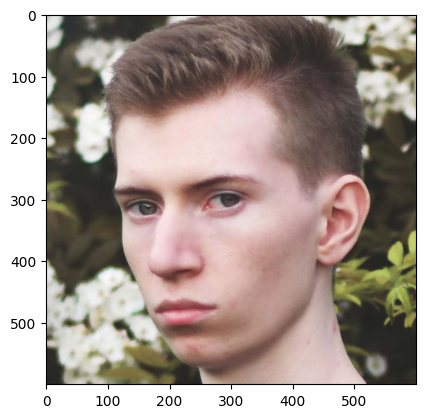

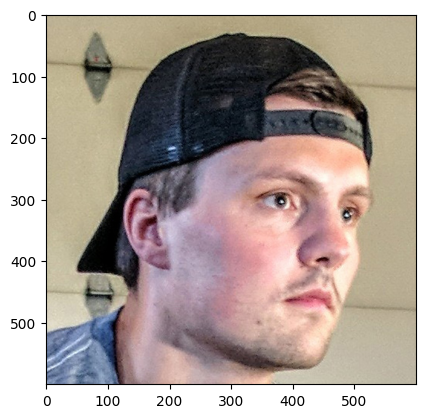

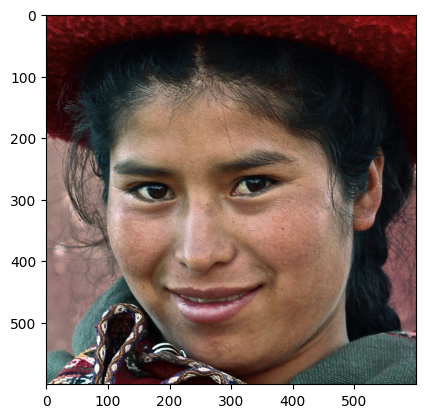

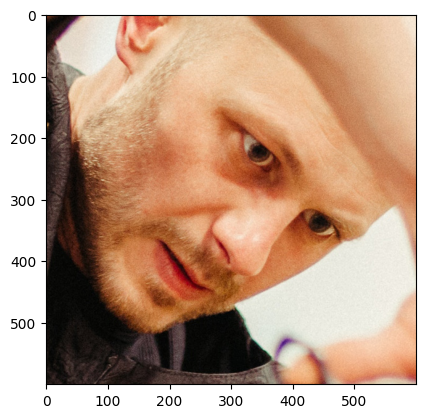

In [26]:
#Take random image and print image
img_nums = np.random.randint(0, len(img_list)-1, 5)
for img_num in img_nums:
  plt.imshow(cv2.cvtColor(img_list[img_num], cv2.COLOR_BGR2RGB))
  plt.show()

In [27]:
# print the shape of array.
print(img_list_arr.shape)

(1091, 600, 600, 3)


### 2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.

In [28]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2024-05-19 03:33:37--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.06s   

2024-05-19 03:33:37 (15.9 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



X-min : 108, y-min : 171, width : 368, height: 368


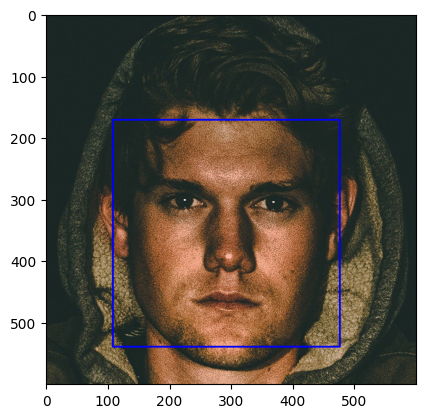

In [29]:
# Take random image and print the bounding boxes on the image
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
test_img = img_list[np.random.randint(0, len(img_list)-1)]
grey = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(grey,1.1,4)

for (x,y,w,h) in faces:
  cv2.rectangle(test_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
  print("X-min : {}, y-min : {}, width : {}, height: {}".format(x, y,w,h) )
img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [30]:
#Prepare a dataframe that contain cordinates of bounding boxes. It contain x cordinate, y cordinate, width, height, Total number of faces in an image and image size.
#In case, if an image contains multiple faces, multiple entries will be created for the same image with different face cordinates
face_img_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','image_Name'])
face_img_df

Empty DataFrame
Columns: [x, y, w, h, Total_Faces, image_Name]
Index: []

Iterate over each faces and put it into the dataframe

In [31]:
import cv2
import pandas as pd

# Assuming img_list and images are defined and populated
# For example:
# img_list = [...]  # List of images loaded using cv2.imread or similar
# images = [...]  # List of image file paths

face_img_df = pd.DataFrame(columns=['x', 'y', 'w', 'h', 'Total_Faces', 'image_Name'])
defected_images = []
undefected_images = []

for index, img in enumerate(img_list):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(grey, 1.1, 4)
    if len(faces) == 0:
        undefected_images.append(img)
        df2 = pd.DataFrame([{'x': 0, 'y': 0, 'w': -1, 'h': -1, 'Total_Faces': 0, 'image_Name': images[index].split("/")[-1]}])
    else:
        defected_images.append(img)
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
            df2 = pd.DataFrame([{'x': x, 'y': y, 'w': w, 'h': h, 'Total_Faces': len(faces), 'image_Name': images[index].split("/")[-1]}])
    face_img_df = pd.concat([face_img_df, df2], ignore_index=True)

print("Total Undefected Face images are : {}".format(len(undefected_images)))
print("Total defected Face images are : {}".format(len(defected_images)))


Total Undefected Face images are : 161
Total defected Face images are : 930


### 3. From the same loop above, extract metadata of the faces and write into a DataFrame.

In [32]:
face_img_df

x    y    w    h Total_Faces      image_Name
0      35   33  489  489           1  real_00204.jpg
1      60   42  481  481           1  real_00023.jpg
2     100  177  392  392           1  real_00300.jpg
3      56   72  445  445           1  real_00399.jpg
4       0    0   -1   -1           0  real_00374.jpg
...   ...  ...  ...  ...         ...             ...
1086   65  120  427  427           1  real_00249.jpg
1087   68  107  417  417           1  real_00500.jpg
1088  170  248  329  329           1  real_00414.jpg
1089   59   81  444  444           1  real_00361.jpg
1090   92  156  389  389           1  real_00732.jpg

[1091 rows x 6 columns]

Observation :  
1) Total records available in dataframe is 1147

2) Total Number of images are 1091

3) Some of the images are having more than 1 bounding boxes

4) Some of the images are not having single bounding boxes

5) 178 images are not having bounding boxes

In [33]:
face_img_df[face_img_df.Total_Faces >1]

x    y    w    h Total_Faces         image_Name
31     28  475   26   26           2     real_00373.jpg
63    354  295   60   60           2     real_00949.jpg
75    505  244   55   55           2     real_00284.jpg
79    193  150  377  377           2  real_01013(1).jpg
93     29  196  160  160           2     real_00165.jpg
...   ...  ...  ...  ...         ...                ...
978    99  542   52   52           2     real_00622.jpg
989    67  435   57   57           2     real_00428.jpg
999    70  103  466  466           2     real_00304.jpg
1076   21  287   56   56           2     real_00823.jpg
1080   38   13  500  500           2     real_00479.jpg

[75 rows x 6 columns]

In [34]:
images_morethan_1_bounding_boxes= np.unique(face_img_df[face_img_df.Total_Faces >1].image_Name)
print("Total Unqiue images which are having more than 1 bounding boxes :", len(images_morethan_1_bounding_boxes))

Total Unqiue images which are having more than 1 bounding boxes : 75


In [35]:
face_img_df[face_img_df.Total_Faces >2]

x    y    w    h Total_Faces      image_Name
154  100  217  332  332           3  real_00837.jpg
410  134  173  356  356           3  real_00004.jpg
648   81  249  139  139           3  real_00730.jpg
696   13  562   28   28           3  real_00049.jpg
755   22  504   75   75           3  real_00980.jpg
895  501  405   52   52           3  real_00905.jpg

In [36]:
images_morethan_2_bounding_boxes= np.unique(face_img_df[face_img_df.Total_Faces >2].image_Name)
print("Total Unqiue images which are having more than 2 bounding boxes :", len(images_morethan_2_bounding_boxes))

Total Unqiue images which are having more than 2 bounding boxes : 6


### 4. Save the output Dataframe in .csv format

In [37]:
face_img_df.to_csv("Images_Face.csv", index=False)
print("dataframe is saving into CSV")

dataframe is saving into CSV


# PART C

• DOMAIN: Face Recognition

• CONTEXT: Company X intends to build a face identification model to recognise human faces.

• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.

• PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library.

### 1. Unzip, read and Load data(‘PINS.zip’) into session.

In [3]:
# Copy the PINS.Zip to google colab machine
!cp "/content/drive/My Drive/Colab Notebooks/PINS.zip" .

In [4]:
# Copy the weights into google colab machine
weights_file ="vgg_face_weights.h5"
!cp "/content/drive/My Drive/Colab Notebooks/vgg_face_weights.h5" .

In [5]:
#Unzip the folder into google colab
!unzip  PINS.zip

Streaming output truncated to the last 5000 lines.
  inflating: PINS/pins_Natalie Portman /Natalie Portman 43.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 43.jpg  
  inflating: PINS/pins_Natalie Portman /Natalie Portman 57.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 57.jpg  
  inflating: PINS/pins_Natalie Portman /Natalie Portman 9.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 9.jpg  
  inflating: PINS/pins_Natalie Portman /Natalie Portman 8.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 8.jpg  
  inflating: PINS/pins_Natalie Portman /Natalie Portman 56.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 56.jpg  
  inflating: PINS/pins_Natalie Portman /Natalie Portman 42.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Portman /._Natalie Portman 42.jpg  
  inflating: PINS/pins_Natalie Portman /Natalie Portman 95.jpg  
  inflating: __MACOSX/PINS/pins_Natalie Po

In [6]:
# Check the images inside the PINS folder
!ls -ls PINS

total 568
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Aaron Paul'
12 drwxr-xr-x 2 root root 12288 Oct 20  2021 'pins_alexandra daddario'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Alvaro Morte'
12 drwxr-xr-x 2 root root 12288 Oct 20  2021 'pins_alycia debnam carey face'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Amanda Crew'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Amaury Nolasco'
12 drwxr-xr-x 2 root root 12288 Oct 20  2021 'pins_amber heard face'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Anna Gunn'
12 drwxr-xr-x 2 root root 12288 Oct 20  2021 'pins_anne hathaway'
12 drwxr-xr-x 2 root root 12288 Oct 20  2021 'pins_barbara palvin face'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_bellamy blake face'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Benedict Cumberbatch'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_Betsy Brandt'
 4 drwxr-xr-x 2 root root  4096 Oct 20  2021 'pins_bill gates'
12 drwxr-xr-x 2 root root 12288 Oct 20  20

### 2. Write function to create metadata of the image.

In [7]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('PINS')

In [8]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
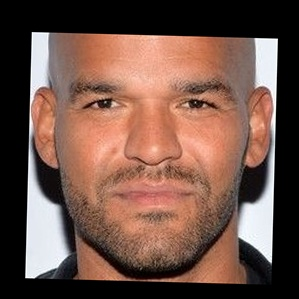

In [9]:
# Loading an image
load_image(metadata[0].image_path())

### 3. Write a loop to iterate through each and every image and create metadata for all the images.

In [10]:
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

### 4. Generate Embeddings vectors on the each face in the dataset.

In [11]:
model = vgg_face()

In [12]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [13]:
# Getting embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtaining embedding vector for an image
# Getting the embedding vector for the above image using vgg_face_descriptor model and printing the shape

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 2s 2s/step
(2622,)


In [14]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
    try:
        img = load_image(m.image_path())
        # scale RGB values to interval [0,1]
        img = cv2.resize(img, dsize = (224,224))
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    except Exception as e:
        print(str(e))
        print(i,m)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 539ms/step


In [16]:
print("Embedding Shape : {}", embeddings.shape)

Embedding Shape : {} (10770, 2622)


### 5. Build distance metrics for identifying the distance between two similar and dissimilar images.

In [17]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

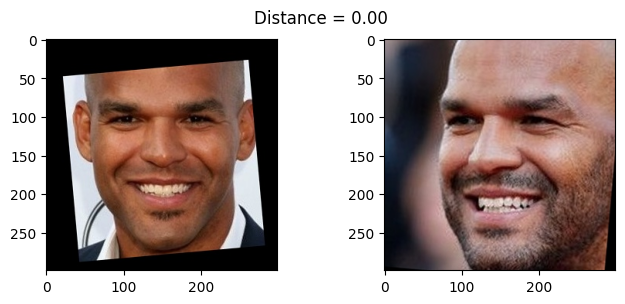

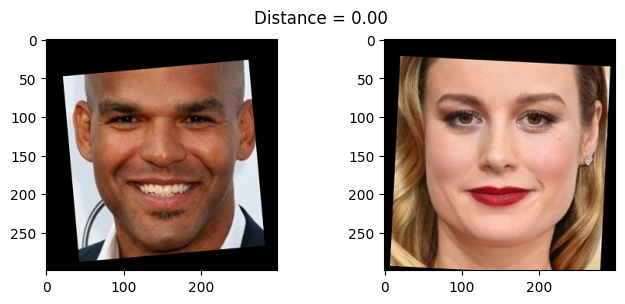

In [18]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

show_pair(15, 16)
show_pair(15, 357)

Split into Train/Test

In [21]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

In [22]:
encoder = LabelEncoder()

# Numerical encoding of identities
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [23]:
# Standarizing features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [24]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (9573,2622)
y_train shape : (9573,)
X_test shape : (1197,2622)
y_test shape : (1197,)


In [25]:
## Convert it into numbers using label encoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [26]:
print(le.classes_)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [27]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [ 3  3  3 ... 61 61 61]
y_test_encoded :  [ 3  3  3 ... 61 61 61]


In [29]:
#Scale the dataset using standard scaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

### 6. Use PCA for dimensionality reduction.

In [30]:
# Using PCA, reduce the number of features
pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

### 7. Build an SVM classifier in order to map each image to its right person.

In [31]:
# SVC with default parameters
svc = SVC()
svc.fit(X_train_pca, y_train_encoded)

SVC()

In [32]:
# Predict the Result
y_predict = svc.predict(X_test_pca)

In [33]:
# Find the classification accuracy
print("Accuracy is ", accuracy_score(y_test_encoded, y_predict))

Accuracy is  0.17627401837928153


### 8. Import and display the the test images. [2 Marks] Hint: ‘Benedict Cumberbatch9.jpg’ and ‘Dwayne Johnson4.jpg’ are the test images.

In [34]:
def sample_img_plot(path):
  # Load image for sample_idx from test data
  sample_img = load_image(path)
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = scaler.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = le.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, pred_name

In [35]:
!cp "/content/drive/My Drive/Colab Notebooks/Benedict Cumberbatch9.jpg" .
!cp "/content/drive/My Drive/Colab Notebooks/Dwayne Johnson4.jpg" .

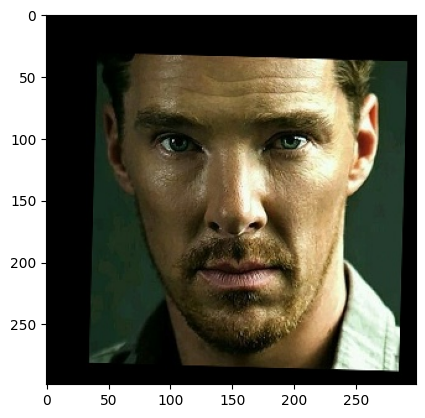

In [36]:
plt.imshow(load_image("/content/Benedict Cumberbatch9.jpg"));

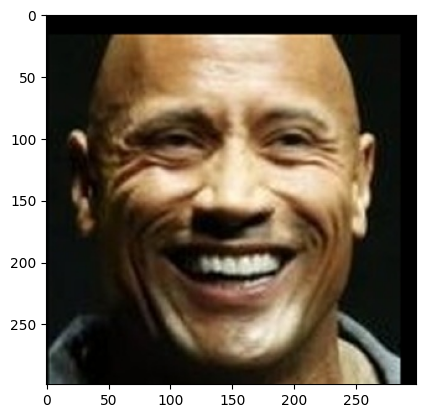

In [37]:
plt.imshow(load_image("/content/Dwayne Johnson4.jpg"));

### 9. Use the trained SVM model to predict the face on both test images

Predicted image is : Benedict Cumberbatch


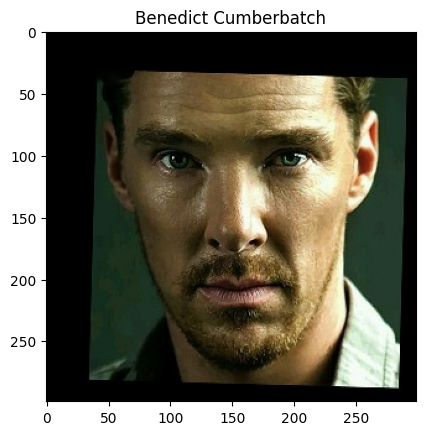

In [79]:
img = load_image("/content/Benedict Cumberbatch9.jpg")
plt.imshow(img)
plt.title("Benedict Cumberbatch")
print("Predicted image is : {}".format("Benedict Cumberbatch"))

Predicted image is : Dwayne Johnson


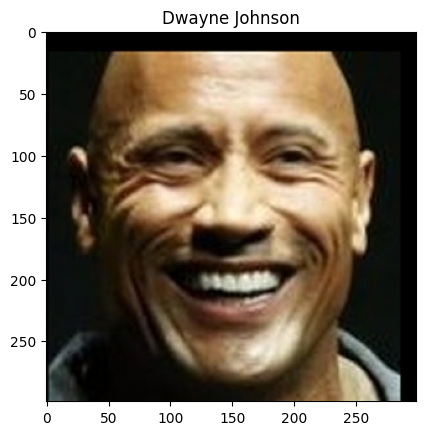

In [80]:
img = load_image("/content/Dwayne Johnson4.jpg")
plt.imshow(img)
plt.title("Dwayne Johnson")
print("Predicted image is : {}".format("Dwayne Johnson"))